In [1]:
from qalcore.qiskit.vqls.vqls import VQLS, VQLSLog
from qiskit.primitives import Estimator, Sampler 
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit import Aer
import numpy as np

# Variational Quantum Linear Solver

The VQLS is an hybrod variational method to solve linear systems 

$$
A \cdot x = b
$$

where $A$ is a square (symmetric) matrix and $b$ the solution vector. The matrix $A$ should be expressed as a sum of unitary matrices :

$$
A = \sum_n c_n A_n
$$

VQLS soves for $x$ by creating a variational ansatz $|\Psi(\theta)\rangle = V(\theta)|0\rangle$ and a transformation $U$ such as $|b\rangle U|0\rangle$. The solution vector $|x\rangle$ is then obtained by optimizing the parameters $\theta$ to minimize the cost function :

$$
C = \langle \psi(\theta) A^\dagger | (\mathbb{I} - |b\rangle\langle b|) | A \psi(\theta) \rangle
$$

A great tutorial on VQLS can be found on the qiskit [documentation](https://qiskit.org/textbook/ch-paper-implementations/vqls.html), and more details can be found in the original [article](https://arxiv.org/abs/1909.05820)

# Define the system
Let's start by creating a random symmetric 4x4 matrix $A$

In [2]:
nqbit = 2
size = 2**nqbit
A = np.random.rand(size, size)
A = A + A.T

and a random solution vector $b$

In [3]:
b = np.random.rand(size)

We can use the `NumpyLinearSolver` class to obtain the solution of this very simple system

In [4]:
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
classical_solution = NumPyLinearSolver().solve(A, b / np.linalg.norm(b))

/tmp/ipykernel_4544/2242500068.py:2: DeprecationWarning: The NumPyLinearSolver class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  classical_solution = NumPyLinearSolver().solve(A, b / np.linalg.norm(b))


# Define the variational ansatz
Qiskit contains a series of variational circtuits that can be used to define variational ansatz. We will use here the so-called `RealAmplitude` circuit. Since our matrix is 4x4 we will use 2 qbits.

In [5]:
ansatz = RealAmplitudes(nqbit, entanglement="full", reps=3, insert_barriers=False)

We can now call the VQLS class to initialize the solver. We use here a statevector backend to obtain very accurate results

In [9]:
log = VQLSLog([],[])
estimator = Estimator()
sampler = Sampler()
vqls = VQLS(
    estimator,
    ansatz,
    COBYLA(maxiter=200, disp=True),
    sampler=sampler,
    callback=log.update 
)

We can then use the solver to obtain the solution of the linear system

In [10]:
opt= {"use_overlap_test": False,
      "use_local_cost_function": False}
res = vqls.solve(A, b, opt)

VQLS Iteration 196 Cost 4.4669474064118475e-07
   Normal return from subroutine COBYLA

   NFVALS =  196   F = 4.466947E-07    MAXCV = 0.000000E+00
   X =-9.605506E-01  -4.985257E-01   1.016218E+00  -3.514202E+00   2.443166E+00
      -2.555268E+00   2.734173E+00  -3.087236E+00


The accuracy of the solution obtained with the VQLS solver can be estimated by comparing the solution vectors obtained with VQLS and the numpy solver

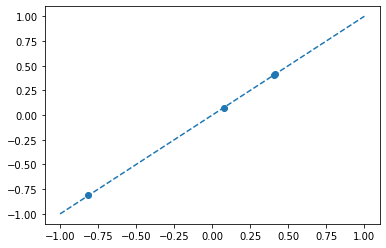

In [14]:
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

ref_solution = classical_solution.state / np.linalg.norm(classical_solution.state)
vqls_solution = np.real(Statevector(res.state).data)


plt.scatter(ref_solution, -vqls_solution)
plt.plot([-1, 1], [-1, 1], "--")

Text(0.5, 0, 'Iterations')

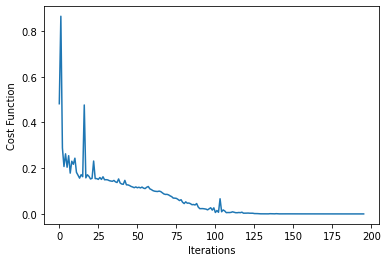

In [13]:
plt.plot(log.values)
plt.ylabel('Cost Function')
plt.xlabel('Iterations')